## LandCoverNet Model Training

<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

This tutorial delves into building a scalable model on the LandCoverNet dataset.

This portion of the tutorial is focused on developing a semantic segmentation model for LandCoverNet data

Here:

1. We will load the prepared data as into the non-overlapping training, test and validation data sets

4. We will build a segmentation model, train it on the training data, inspect the results on the validation data and make predictions on the test data

#### Importing the needed libraries

In [141]:
import numpy as np
import pandas as pd

import contextlib
import warnings

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import pickle
import random
warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

### Loading the data

We will then load the prepared data defined by the least cloudy RGB source images across all labels taken quarterly throughout the year (every three months).

In [2]:
tmp_dir=!pwd
tmp_dir=tmp_dir[0]

In [3]:
tmp_dir

'/home/jovyan/PlanetaryComputerExamples/landcovnet'

In [3]:
with open (f'{tmp_dir}/items.pkl', 'rb') as fp:
    Xys = pickle.load(fp)

Next, we will extract the images and labels respectively.

Since we extracted three RGB images from each season from the data preparation notebook, we will combine/concatenate those images into a single numpy array consisting of (3x3)= 9 bands

In [4]:
def process_xy(Xys): #process x and y
    total=0
    temp=[]
    total_list=[]
    for i in range (0, len(Xys)):
        temp.append(Xys[i][0].data)
    for i in range(0,len(Xys)):
        total+=len(Xys[i][0])
        total_list.append(total) #this saves the index of the label's first image, then the next label's first image, etc.
    # print(temp.shape)
    for i in range(0,len(total_list)-1):
        if total_list[i+1]!=total_list[i]+3: #the label does not contain four source images
            outlier=total_list[i]
    temp = [it for sub in temp for it in sub]
    temp = np.asarray(temp)
    temp = temp.swapaxes(1,2) #transform axis to desired shape
    temp = temp.swapaxes(2,3)
    X_mod=[]
    for item in range(0,len(temp)):
        if item==outlier:
            pass
        else:
            X_mod.append(list(temp[item]))
    del temp
    del total_list
    X_mod=np.asarray(X_mod)
    flat_list=[]
    for i in range(0,len(X_mod),3):
        flat_list.append(list(np.concatenate(X_mod[i:i+3], axis=2)))#roll the data  
    flat_list=np.asarray(flat_list)
    del X_mod
    Y= np.zeros((len(Xys), 256, 256), dtype=np.float32)
    i=0
    for j in range(0,len(Xys)): #duplicate the labels for the source images belonging to a label item
        Y[j]=Xys[j][1][0].data
        #i+=1
        # Y[j][:,:,0] = Xys[j][1][0].data # same value in each channel
        # Y[j][:,:,1] = Xys[j][1][0].data
        # Y[j][:,:,2] = Xys[j][1][0].data
        # Y[j][:,:,3] = Xys[j][1][0].data
        # Y[j][:,:,4] = Xys[j][1][0].data
        # Y[j][:,:,5] = Xys[j][1][0].data
        # Y[j][:,:,6] = Xys[j][1][0].data
        # Y[j][:,:,7] = Xys[j][1][0].data
        # Y[j][:,:,8] = Xys[j][1][0].data
    return flat_list,Y

In [5]:
X,Y=process_xy(Xys) #extract x and y

#### Splitting the data

We will split the data into three non-overlapping data sets; the training, validation and test data sets.

Much of the training will be on the training set, containing 70% of the data, while the validation and test sets will contain 30% of the data (15% each).

We will also use one-hot encoded labels for the training and validation data.
This will make each an array containing either 0 or 1 where the array having 1 at index i signifies the one-hot encoded form of the (i+1)th class label.

For example, say we have `arrays = [3,2,1]`, then the one-hot encoded variable of `arrays` will be `[[0,0,1],[0,1,0],[1,0,0]]` where the first array ( `[0,0,1]` ) having 1 at index 2 signifies the one-hot encoded form of the third label.

Similarly, the second array ( `[0,1,0]` ) having 1 at index 1 is the one-hot encoded form of the second label.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X[0:400], Y[0:400], test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
del X #clear memory
del Y

In [138]:
import gc
gc.collect()

15688

In [7]:
from tensorflow.keras.utils import to_categorical #one hot encoding done for labels
y_tr= to_categorical(y_train, num_classes=8) #for train
y_v= to_categorical(y_val, num_classes=8) #for validation

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(140, 256, 256, 9)
(140, 256, 256, 8)
(30, 256, 256, 9)
(30, 256, 256, 8)
(30, 256, 256, 9)
(30, 256, 256)


We will just make a sanity check by visualising a random training image and its label to make sure they fit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


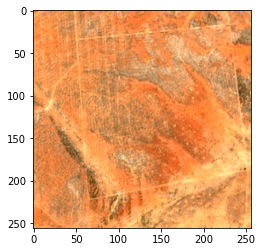

In [28]:
#view a random image
train_id = random.randint(0, len(train_id)-1)
plt.imshow(x_train[train_id][:,:,3:6]*2) #chose the second image [3:6] in the concatenated image

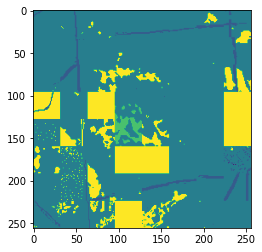

In [25]:
plt.imshow(y_train[train_id]) #display corresponding label

#### Check for Class Imbalance

We will then inspect for the number of pixels in total occupied by each label/class in the training data to see if we have cases of class imbalance

In [153]:
(unique,counts)=np.unique(y_train,return_counts=True)
print(unique,counts)

[0. 1. 2. 3. 4. 5. 6. 7.] [   6323  320010  534616 4681163    4298 4630723 3396156 4776791]


As we can see, there's under-representation in the first label (0) and over-representation of the eight label (7).
This would cause the model to mostly classify the eight label and should be addressed.

To address this, we will use class weights in our loss function for our model development.
The class weight of each class is simply the inverse of the frequency of occurrence of each class in the data, as seen in the implementation below

In [152]:
sum=0
percentage=[]
for i in counts:
    sum+=i
for i in counts:
    percentage.append(1/(i/sum*100))
percentage

[29.021160841372772,
 0.5734220805599826,
 0.3432385113801308,
 0.039199831323968,
 42.694462540716614,
 0.039626814214540576,
 0.05403191137274024,
 0.038415078239763895]

In [90]:
def weighted_categorical_crossentropy(weights= percentage): #weights for loss function
    print('The used loss function is: weighted categorical crossentropy')
    def wcce(y_true, y_pred):
        Kweights = K.constant(weights)
        if not tf.is_tensor(y_pred): y_pred = K.constant(y_pred)
        y_true = K.cast(y_true, y_pred.dtype)
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
    return wcce

#### Building the Model

In [164]:

def unet(pretrained_weights = None, input_size = (256,256,9), weights=percentage,\
         activation='relu', dropout=0, loss='categorical_crossentropy', optimizer='adam',\
             dilation_rate=(1,1), reg=0.01):
    #code reference: https://github.com/aritzLizoain/CNN-Image-Segmentation
    inputs = Input(input_size)
    s = Lambda(lambda x: x) (inputs)
    
    #CONTRACTIVE Path (ENCODER)    
    
    # cm3 = Conv2D(2, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (s)
    # cm3 = Dropout(dropout) (cm2)
    # cm3 = Conv2D(2, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (cm2)
    # pm3 = MaxPooling2D((2, 2)) (cm2)
    # pm3 = BatchNormalization()(pm2)
    
    # cm2 = Conv2D(4, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (s)
    # cm2 = Dropout(dropout) (cm2)
    # cm2 = Conv2D(4, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (cm2)
    # pm2 = MaxPooling2D((2, 2)) (cm2)
    # pm2 = BatchNormalization()(pm2)

    # cm1 = Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (s)
    # cm1 = Dropout(dropout) (cm1)
    # cm1 = Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (cm1)
    # pm1 = MaxPooling2D((2, 2)) (cm1)
    # pm1 = BatchNormalization()(pm1)
    
    # c0 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (pm1)
    # c0 = Dropout(dropout) (c0)
    # c0 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (c0)
    # p0 = MaxPooling2D((2, 2)) (c0)
    # p0 = BatchNormalization()(p0)

    c1 = Conv2D(32, 3 , activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (s)
    c1 = Dropout(dropout) (c1)
    c1 = Conv2D(32, 3 , activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    # p1 = BatchNormalization()(p1)

    c2 = Conv2D(64, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p1)
    c2 = Dropout(dropout) (c2)
    c2 = Conv2D(64, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    # p2 = BatchNormalization()(p2)

    c3 = Conv2D(128, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p2)
    c3 = Dropout(dropout) (c3)
    c3 = Conv2D(128, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    # p3 = BatchNormalization()(p3)

    c4 = Conv2D(256, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p3)
    c4 = Dropout(dropout) (c4)
    c4 = Conv2D(256, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    # p4 = BatchNormalization()(p4)

    c5 = Conv2D(512, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (p4)
    c5 = Dropout(dropout) (c5)
    c5 = Conv2D(512, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c5)


    #EXPANSIVE Path (DECODER)
    
    u6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u6)
    c6 = Dropout(dropout) (c6)
    c6 = Conv2D(256, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c6)
    
    u7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u7)
    c7 = Dropout(dropout) (c7)
    c7 = Conv2D(128, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c7)
    
    u8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u8)
    c8 = Dropout(dropout) (c8)
    c8 = Conv2D(64, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c8)

    u9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (u9)
    c9 = Dropout(dropout) (c9)
    c9 = Conv2D(32, 3, activation=activation, dilation_rate=dilation_rate, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg)) (c9)
    
    # u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
    # u10 = concatenate([u10, c0], axis=3)
    # c10 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (u10)
    # c10 = Dropout(dropout) (c10)
    # c10 = Conv2D(16, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (c10)
    
    # u11 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c10)
    # u11 = concatenate([u11, cm1], axis=3)
    # c11 = Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (u11)
    # c11 = Dropout(dropout) (c11)
    # c11 = Conv2D(8, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (c11)

    # u12 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (c10)
    # u12 = concatenate([u12, cm2], axis=3)
    # c12 = Conv2D(4, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (u12)
    # c12 = Dropout(dropout) (c12)
    # c12 = Conv2D(4, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (c12)

    # u13 = Conv2DTranspose(2, (2, 2), strides=(2, 2), padding='same') (c11)
    # u13 = concatenate([u12, cm2], axis=3)
    # c13 = Conv2D(2, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (u12)
    # c13 = Dropout(dropout) (c12)
    # c13 = Conv2D(2, (3, 3), activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(0.01)) (c12)
 
    #softmax as activaition in the last layer
    outputs = Conv2D(8, 1, activation='softmax') (c9) 

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=optimizer, loss=loss,\
                  metrics = ['accuracy'])
    model.summary() 
    
    if(pretrained_weights):
        
        print('Using {0} pretrained weights'.format(pretrained_weights))
    
        model.load_weights(pretrained_weights)

    return model

In [165]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
#IMG_CHANNELS=8 #number of classes
input_size = (IMG_HEIGHT, IMG_WIDTH, 9)

In [166]:
weights= percentage
pretrained_weights = None
activation = 'elu'
dropout = 0.18 # (default 0.0)
dilation_rate = 1 # (default (1,1))
loss = weighted_categorical_crossentropy(weights) # (default 'categorical crossentropy')
reg = 0.01 # (default 0.01) L2 regularization
# learning_rate =  0.0001 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, epsilon=1e-07, name="Adam", clipnorm=0.5
) # (default 'adam')clipnorm=1.0
model = unet(pretrained_weights = pretrained_weights, input_size = input_size, weights = weights,\
         activation=activation, dropout=dropout, loss=loss, optimizer=optimizer, dilation_rate=dilation_rate)

The used loss function is: weighted categorical crossentropy
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256, 256, 9) 0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 256, 256, 9)  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_285 (Conv2D)             (None, 256, 256, 32) 2624        lambda_11[0][0]                  
__________________________________________________________________________________________________
dropout_95 (Dropout)            (None, 256, 256, 32) 0           conv2d_285[0][0]                 
______________________________

In [108]:
batch_size=8

In [167]:
history = model.fit(x=x_train, y=y_tr,
              validation_data=(x_val, y_v),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=8, epochs=10)

Epoch 1/10
35/35 [==============================] - 9s 202ms/step - loss: nan - accuracy: 0.1238 - val_loss: nan - val_accuracy: 0.0660
Epoch 2/10
35/35 [==============================] - 7s 193ms/step - loss: nan - accuracy: 0.0891 - val_loss: nan - val_accuracy: 0.0389
Epoch 3/10
35/35 [==============================] - 7s 194ms/step - loss: nan - accuracy: 0.1275 - val_loss: nan - val_accuracy: 5.2261e-04
Epoch 4/10
35/35 [==============================] - 7s 194ms/step - loss: nan - accuracy: 0.0393 - val_loss: nan - val_accuracy: 0.2510
Epoch 5/10
35/35 [==============================] - 7s 194ms/step - loss: nan - accuracy: 0.1984 - val_loss: nan - val_accuracy: 0.2475
Epoch 6/10
35/35 [==============================] - 7s 195ms/step - loss: nan - accuracy: 0.0574 - val_loss: nan - val_accuracy: 3.1253e-04
Epoch 7/10
35/35 [==============================] - 7s 194ms/step - loss: nan - accuracy: 0.0808 - val_loss: nan - val_accuracy: 0.2039
Epoch 8/10
35/35 [======================

#### Building the U-Net architecture (No Imbalance check)
This model was thanks to YOUCEF GUICHI on Kaggle's  Aerial Semantic Segmentation Drone Dataset.

Their implementation can be found [here](https://www.kaggle.com/yesa911/aerial-semantic-segmentation-96-acc).

For this tutorial, some tweaks were made on the referenced implementation to suit our application

In [8]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [85]:
def unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=8):
    
    inputs = Input(input_size)
    #inputs = BatchNormalization()(inputs) # we can learn the normalization step
    #inputs = Dropout(0.5)(inputs)    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)  
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    #conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [147]:
img_height = 256
img_width = 256
num_channels = 9

unet = unet_model((img_height, img_width, num_channels))

In [193]:
unet.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 9) 0                                            
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 256, 256, 128 10496       input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 256, 256, 128 147584      conv2d_220[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_44 (MaxPooling2D) (None, 128, 128, 128 0           conv2d_221[0][0]                 
___________________________________________________________________________________________

#### Helper Functions During Model Training

ZAKIR ZEYNALOV on Kaggle for the same Aerial Semantic Segmentation Drone Dataset, made some useful helper functions below which can be used in conjuction with training.
Their implementation can be found [here](https://www.kaggle.com/menhior/aerial-drone-shots-image-segmentation)

They can be included in `unet.fit` for the callback parameter as shown in the comments for the code at the model training stage.

Since we were running across 100 epochs, they weren't included to make the output simple, although this applies particularly to `DisplayCallback()`. `ModelCheckpoint` and `EarlyStopping` can still be included for saving the model at the epoch with the best result and interrupting training when there's no improvement in results respectively (in our case, we chose 50 epochs).

In [16]:
model_checkpoint = ModelCheckpoint(tmp_dir+'/unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [21]:
history = unet.fit(x=x_train, y=y_tr,
              validation_data=(x_val, y_v),
              steps_per_epoch = 2048//batch_size,
              validation_steps = 256//batch_size,
              batch_size=16, epochs=20, callbacks=[model_checkpoint])

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
# Get training and test loss histories
training_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [102]:
import random
i=random.randint(0, len(x_test)-1)
pred_mask = model.predict(np.expand_dims(x_train[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]

In [168]:
pred_mask[1]

array([2, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5])

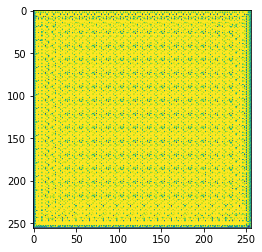

In [169]:
plt.imshow(pred_mask)

1/1 [==============================] - 0s 18ms/step - loss: 0.0155 - accuracy: 0.9998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.015507618896663189, 0.9998321533203125]
14


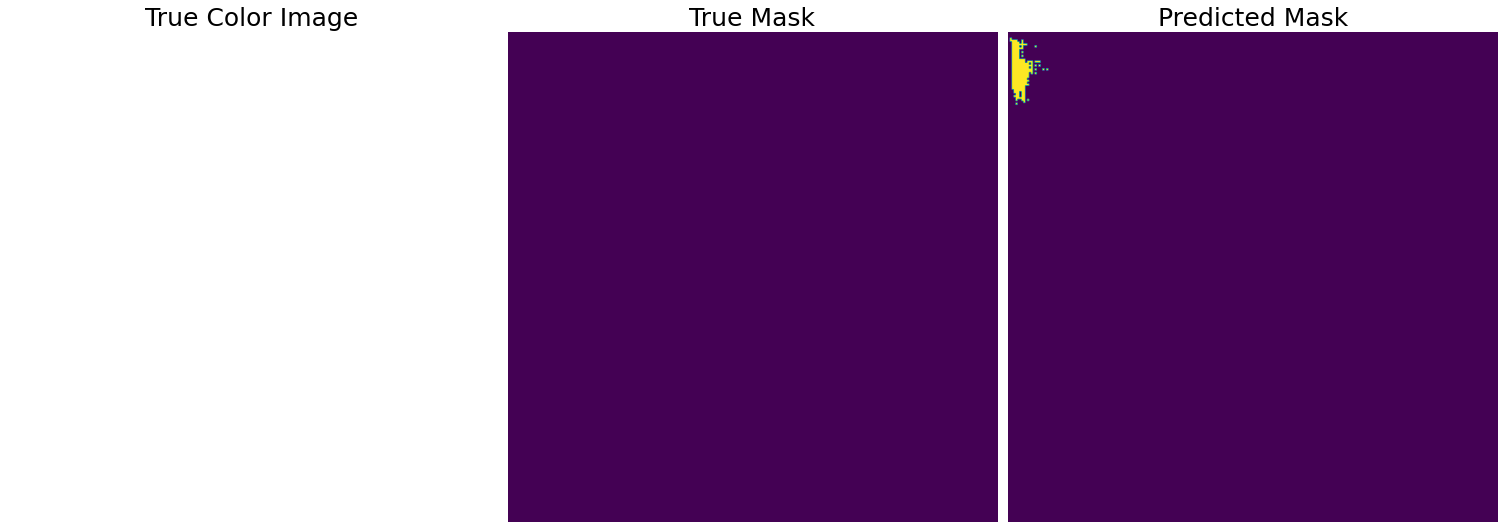

In [25]:
import random
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21,10.80))
i=random.randint(0, len(x_test)-1)
test_result= unet.evaluate(np.expand_dims(x_train[i], 0),np.expand_dims(y_train[i], 0))
pred_mask = unet.predict(np.expand_dims(x_test[i], 0))
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]
print(test_result) #print results on the random field
print (i) #print ID
# Perform a sanity check on some random training samples
plt.subplot(1, 3, 1)
fontsize =25
axes[0].imshow(x_test[i]*2)
plt.title("True Color Image", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1, 3, 2)
axes[1].imshow(y_test[i])
plt.title("True Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
plt.subplot(1,3,3)
axes[2].imshow(pred_mask) #prediction without threshold
plt.title("Predicted Mask", fontdict={'fontsize': fontsize})
plt.axis('off')
fig.tight_layout()